In [2]:
import sys
sys.path.append('../datasets')

import torch
import matplotlib.pyplot as plt

from torchvision import transforms
from torch.linalg import svd
from math import sqrt

from datasets import HSIDataset

In [4]:
# Define device (default is "cpu")
device = "cpu"

# Define dtype
dtype = torch.float32

# Define random seed
seed = 42
torch.manual_seed(seed)

# Define data path
data_path = '/home/y/Documents/Data/HSI/hyspecnet-11k/datasets/hyspecnet-11k.zarr'

In [5]:
# Loads ENMAP Hypecnet Datasets 
val_transform = transforms.Compose([transforms.ToTensor()]) # Transforms a the input data to torch tensors
dataset = HSIDataset(root_dir=data_path, split='test', transform=val_transform)

# Choose the index of the selected image in the dataset (ENMAP dataset contains 11 000 images)
idx = 1131 
x = dataset[idx].unsqueeze(0).to(device=device,dtype=dtype) # import image to device (cpu or gpu), sizes of x is [1,number of bands, width, height]
# Adds a small amount of white gaussian noise to the input HSI (sigma2 = 1e-4)
x += 1e-2*torch.rand_like(x, device=device, dtype=dtype)

# Compute the panchromatic image from the ground truth HSI
panc = torch.sum(x, dim=1).unsqueeze(1)/x.shape[1]

# Adds noise to the input HSI
sigma2 = 0.001
y = x + sqrt(sigma2)*torch.randn_like(x, device=device, dtype=dtype)


## Eigenimages

---
An Hyperspectral Image (HSI) composed of $m$ bands and $n$ pixels is expressed a matrix of size $m\times n$ :
$$
    X = [x_1, \dots, x_n] \in \mathbb{R}^{m\times n},
$$
in which each $x_i$ is the $m$-dimensional spectral vector associated to the $i^{th}$ pixel.

---
We assume that the spectral vector live in $k$-dimensional subspace, and write,
$$
X = EZ.
$$
where $E\in\mathbb{R}^{m\times k}$ stores the basis vector and $Z\in\mathbb{R}^{k\times n}$ the coefficients of each spectra.

In this context, an **eigenimage** is an image of coefficient for a specific vector ($Z_{i,:}$).

---
In this script, we compute the basis vector using an SVD.




In [6]:
# Reshape HSI cubes to matrices of size [number of bands, number of pixels]
x_mat = x.reshape(x.shape[1], -1)
y_mat = y.reshape(y.shape[1], -1)

# Singular Value Decomposition of noisy and true HSI
U, s, V = svd(x_mat, full_matrices=False)
U_noisy, s_noisy, V_noisy = svd(y_mat, full_matrices=False)

# Eigenimages are the coefficient images of each HSI in the basis formed by its eigenvectors
Z_mat = torch.diag(s) @ V
Z = Z_mat.reshape(x.shape)

Z_mat_noisy = torch.diag(s_noisy) @ V_noisy
Z_noisy = Z_mat_noisy.reshape(y.shape)

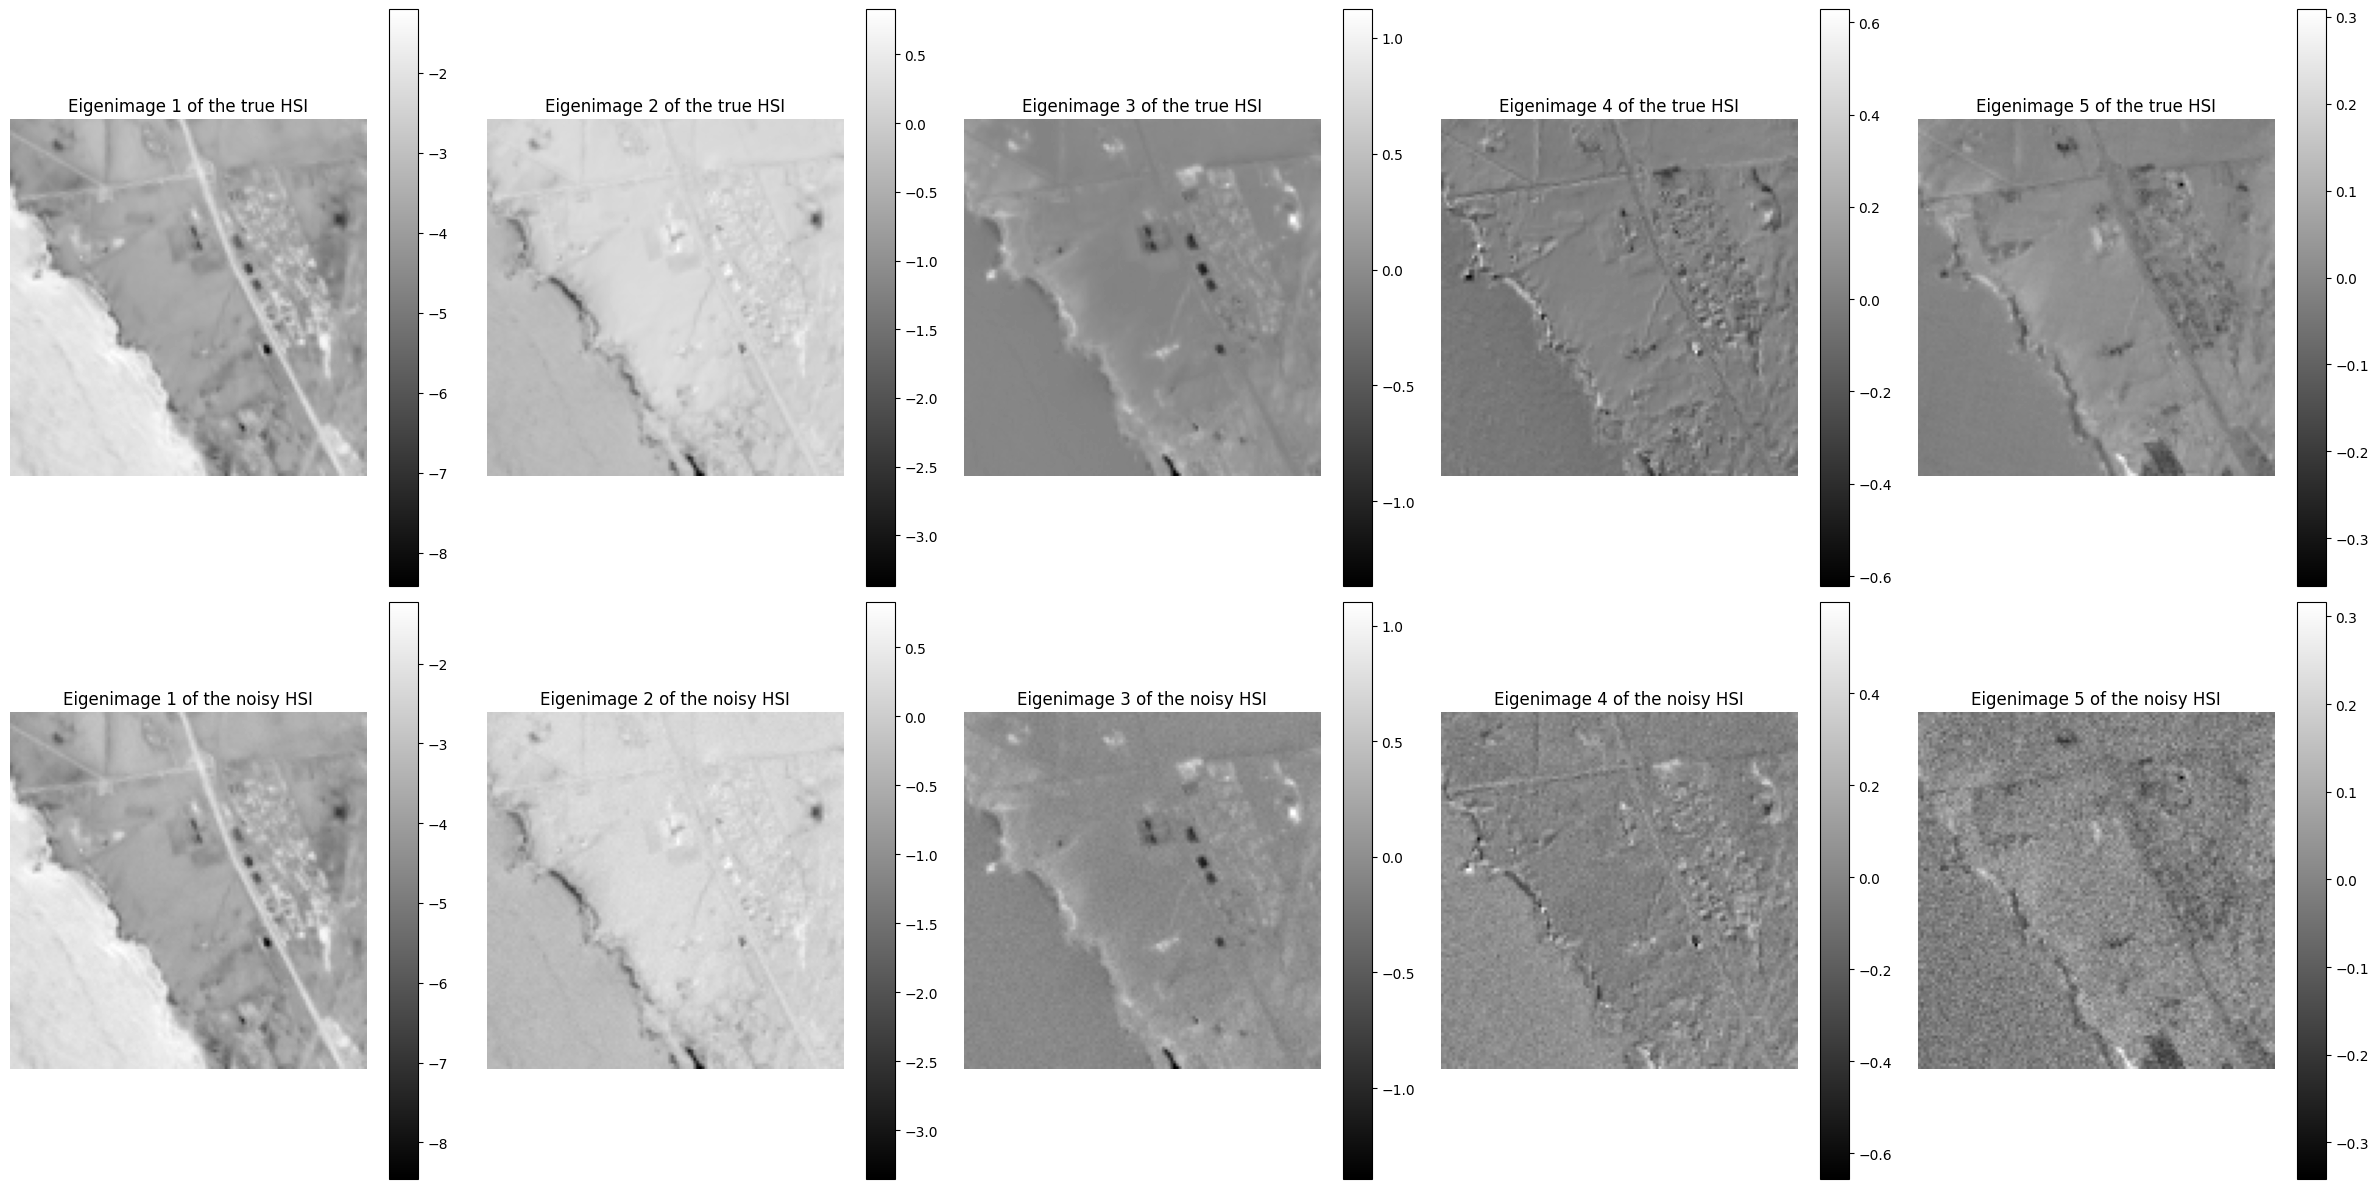

In [12]:
# Plot the 4 first eigenimages withe colorbar

plt.figure(figsize=(24, 12))
for i in range(5):
    plt.subplot(2, 5, i+1)
    plt.imshow(Z[0, i, :, :], cmap='gray')
    plt.colorbar()
    plt.title('Eigenimage '+str(i+1)+' of the true HSI')
    plt.axis('off')
    plt.subplot(2, 5, i+6)
    plt.imshow(Z_noisy[0, i, :, :], cmap='gray')
    plt.colorbar()
    plt.title('Eigenimage '+str(i+1)+' of the noisy HSI')
    plt.axis('off')
plt.tight_layout()
plt.show()

